# Project 4: The Solar Atmosphere: Stratification and Continuous Spectrum

Candidate: 15904 and 15909

Imports needed to solve the following problems.

In [12]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [13]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy import units
from astropy import constants
from astropy.table import QTable  # to use tables with units
from astropy.modeling.models import BlackBody  # to compute the Planck function
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats
from numpy import newaxis as nax  # to simplify the many uses of this

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(7, 7 / 1.75)) # Larger figure sizes
plt.rc('font', size=12)

from scipy.integrate import cumtrapz   # for tau integration
from scipy.special import wofz   # for Voigt function

i_units = "kW m-2 sr-1 nm-1"  # More practical SI units

In [14]:
def read_table_units(filename):
    """
    Reads a table in a text file, formatted with column names in first row,
    and unit names on second row. Any deviation from this format will fail.
    """
    tmp = np.genfromtxt(filename, names=True)
    unit_names = open(filename).readlines()[1][1:].split()
    # Convert to astropy QTable to have units
    data = QTable(tmp)
    # Assign units to quantities in table, use SI units
    for key, unit in zip(data.keys(), unit_names):
        data[key].unit = unit
        data[key] = data[key].si  # We don't want to use deprecated units
    return data

In the first part of this project we will study the radial stratification of the solar atmosphere and solve different exercises by use of data from the (1D) FALC model. This is a semi-empirical model, meaning that it was derived by a combination of physics and emirical adjustments, with the goal that its properties should match the observations of the Sun as much as possible. 
After looking at the FALC model, we want to study the formation of the solar continuum radiation, and we will only be concentrating on the visible and near-infrared parts of its spectrum. We will assume that the major provider of continous extinction in the solar photosphere is hydrogen with an extra electron, H$^−$, so we want to calculate the continuous extinction from H$^-$. In the end we want to apply the Thomson scattering and study how this factor will contribute to the total extinction in the solar atmosphere.


### Exercise 1: The FALC Model


<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Plot the total pressure $p_{\rm total}$ against the column mass $m$, both linearly and logarithmically.  You will find that they scale linearly.  Explain what assumption has caused $p_{\rm total} = c\,m$ and determine the value of the solar surface gravity $g_{\rm surface} = c$ that went into the FALC-producing code.
    
Answer:

</div>

First we want to show how the pressure at the solar amtosphere evolves as a functions of the column mass. Both pressure and column mass is found from the semi-empirical FALC model in the `falc.dat` file.  The pressure from the FALC file is the the total pressure $P_{\textrm{total}}$ which is the sum of the gas pressure and the turbulent pressure in the gas. The column mass represents a mass that forms a column with a cross section of 1 m² above some given location.

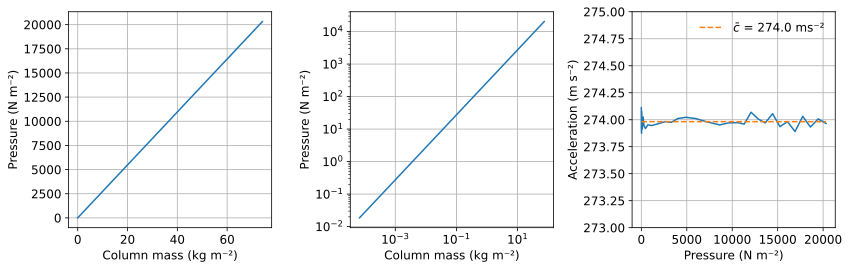

In [15]:
falc = read_table_units("falc.dat")

pressure = falc["pressure"]
colmass = falc["colmass"]

plt.figure(figsize=[12, 4])
plt.subplot(131)
plt.plot(colmass, pressure)
plt.grid()
plt.ylabel("Pressure (N m⁻²)")
plt.xlabel("Column mass (kg m⁻²)")

plt.subplot(132)
plt.loglog(colmass, pressure)
plt.grid()
plt.ylabel("Pressure (N m⁻²)")
plt.xlabel("Column mass (kg m⁻²)")

c = pressure/colmass
plt.subplot(133)
plt.plot(pressure, c)
plt.plot([pressure[0].value, pressure[-1].value], [np.mean(c.value), np.mean(c.value)], "--", label=r"$\bar{c}$ = %.1f ms⁻²" % np.mean(c.value))
plt.xlabel("Pressure (N m⁻²)")
plt.ylabel("Acceleration (m s⁻²)")
plt.ylim(273, 275)
plt.legend()
plt.grid()
plt.tight_layout();


We notice from the left and middle (logarithmic) plot that the pressure $p_{\textrm total}$ evolves linearly with the coloumn mass $m$, i.e. $p_{\textrm total} = c m$ where $c$ is a acceleration constant. The FALC model assume that the photosphere and chromosphere is horizontally homogeneous which imply that pressure will only change in the radial direction as it must be constant elsewhere. This assumption itself is not what shapes the linear curve. The Sun holds on to its mass (mostly) becuase of hydrostatic equillibrium, i.e. a balance between the gravitational pull and the pressure force. The hydrostatic equillibrium causes the pressure and column mass to evolve at the same rate with respect to height which results in these two parameters to evolve linearly with respect to one another. 

We have found that the acceleration constant $c$ are deviated in a relatively small matter around the mean which is $\bar{c} = 274.0$ ms⁻².

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* [Fontenla et al. (1993)](http://adsabs.harvard.edu/abs/1993ApJ...406..319F) also assumed complete mixing, *i.e.* the same elements mix at all heights. Check this by plotting the ratio of the hydrogen mass density to the total mass density against height. Then add helium to hydrogen using their abundance and mass ratios ($N_{\rm He}/N_{\rm H} = 0.1$, $m_{\rm He} = 3.97 \, m_{\rm H}$), and estimate the fraction of the total mass density made up by the remaining elements in the model mix (the "metals").
    
Answer:

</div>

It would be interesting to observe the abundance of different elements in the solar atmosphere as a function of height. We know how the hydrogen density and the total mass density from the FALC model and will be using these data to obtain the hydrogen mass ratio. The mass of the hydrogen ca be found by simply adding the mass of a proton and the mass of a electron. The ratio between the helium and hydrogen densities goes as $N_{\textrm{He}} / N_{\textrm{H}} = 0.1$ and $m_{\textrm{He}} = 3.97 \ m_{\textrm{H}}$ which is used to determine the helium mass ratio. What is left should be other elements which we will not specify other than rest elements.

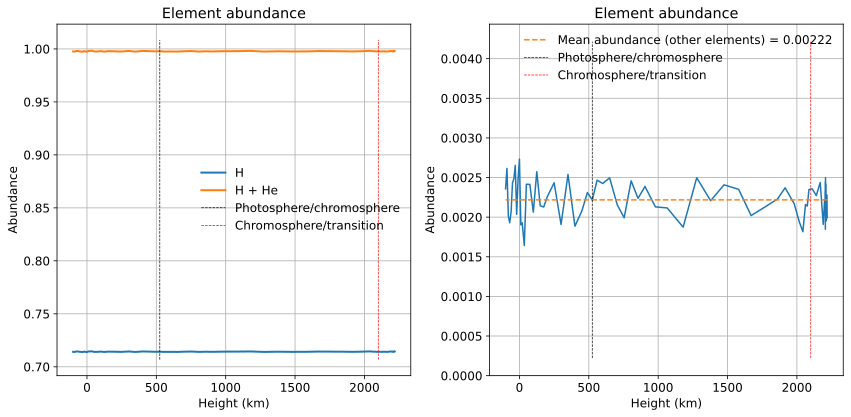

In [16]:
mass_H = constants.m_p + constants.m_e
density_H = falc["hydrogen_density"]
mass_density_H = mass_H * density_H

mass_He = 3.97 * mass_H
density_He = 0.1 * density_H
mass_density_He = mass_He * density_He

height = falc["height"].to('km')
density = falc["density"]

H_abund = mass_density_H / density
H_He_abund = (mass_density_H + mass_density_He)/density

plt.figure(figsize=[12,6])
plt.subplot(121)
plt.plot(height, H_abund, label="H", lw=2)
plt.plot(height, H_He_abund, label="H + He", lw=2)
plt.plot([525,525], [0.99*np.min(H_abund), 1.01*np.max(H_He_abund)], "--", lw=0.7, label="Photosphere/chromosphere", color="black")
plt.plot([2100,2100], [0.99*np.min(H_abund), 1.01*np.max(H_He_abund)], "--", lw=0.7, label="Chromosphere/transition", color="red")
plt.grid()
plt.legend()
plt.title("Element abundance")
plt.xlabel("Height (km)")
plt.ylabel("Abundance")


plt.subplot(122)
rest_abund = 1 - H_He_abund
mean_abund = np.mean(rest_abund)
plt.plot(height, rest_abund)
plt.plot([height[0].value, height[-1].value], [mean_abund, mean_abund],
         "--", label="Mean abundance (other elements) = %.5f" % mean_abund)
plt.plot([525,525], [mean_abund-0.9*mean_abund, mean_abund+0.9*mean_abund], "--", lw=0.7, label="Photosphere/chromosphere", color="black")
plt.plot([2100,2100], [mean_abund-0.9*mean_abund, mean_abund+0.9*mean_abund], "--", lw=0.7, label="Chromosphere/transition", color="red")

plt.ylim([mean_abund-mean_abund, mean_abund+mean_abund])
plt.legend()
plt.grid()
plt.title("Element abundance")
plt.xlabel("Height (km)")
plt.ylabel("Abundance")

plt.tight_layout();


We notice that the abundance of other elements (i.e. not hydrogen or helium) are almost constant, i.e. close to an average of 0.00222 relatively speaking. It may look like the mixing of elements are approximately the same for all height even with these small deviation.

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Create a plot of the gas pressure against height, and then overplot the product $(n_{\rm H} + n_{\rm e}) \, k_B T$. Plot the ratio of the two curves to show their differences.  Do the differences measure deviations from the ideal gas law or something else? Now add the helium density $n_{\rm He}$ to the product and enlarge the deviations. Do you see a pattern emerging? Comment on what could be missing between your calculations and the gas pressure from the model.
    
Answer:

</div>

We want compare the gas pressure from the model with the ideal gas law as a function of height by first plotting them side by side and then plot the ratio between them. The gas should follow the ideal gas law as it is assumed to be in thermodynamic equilibrium. We will introduce the different mass ratios into the calculations and study how they contributes to the pressure in the gas. 

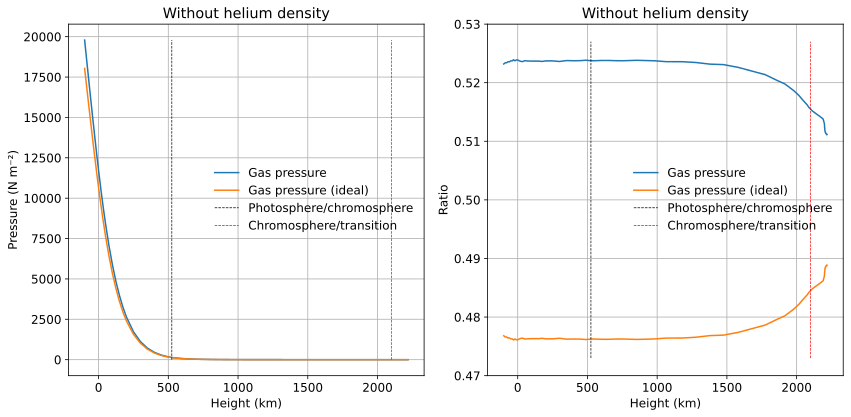

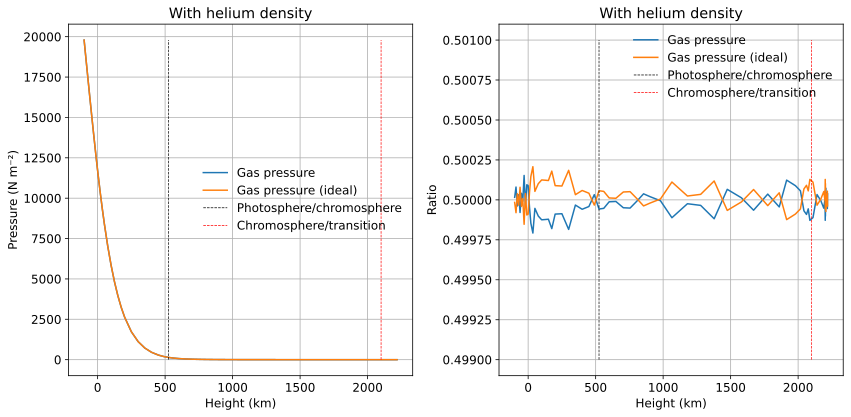

In [17]:
temperature = falc["temperature"]
density_e = falc["electron_density"]
p_gas = pressure - density * falc["v_turb"]**2/2
p_gas_ideal = (density_H + density_e) * constants.k_B * temperature

plt.figure(figsize=[12, 6])
plt.subplot(121)
plt.title("Without helium density")
plt.plot(height, p_gas, label="Gas pressure")
plt.plot(height, p_gas_ideal, label="Gas pressure (ideal)")
plt.plot([525,525], [0, np.max(p_gas).value], "--", lw=0.7, label="Photosphere/chromosphere", color="black")
plt.plot([2100,2100], [0, np.max(p_gas).value], "--", lw=0.7, label="Chromosphere/transition", color="red")
plt.xlabel("Height (km)")
plt.ylabel("Pressure (N m⁻²)")
plt.legend()
plt.grid()


plt.subplot(122)
plt.title("Without helium density")
plt.plot(height, p_gas/(p_gas+p_gas_ideal), label="Gas pressure")
plt.plot(height, p_gas_ideal/(p_gas+p_gas_ideal), label="Gas pressure (ideal)")
plt.plot([525,525], [0.473, 0.527], "--", lw=0.7, label="Photosphere/chromosphere", color="black")
plt.plot([2100,2100], [0.473, 0.527], "--", lw=0.7, label="Chromosphere/transition", color="red")
plt.xlabel("Height (km)")
plt.ylabel("Ratio")
plt.legend()
plt.grid()
plt.ylim([0.47, 0.53])

plt.tight_layout()




p_gas_ideal = (density_H + density_e + density_He) * constants.k_B * temperature

plt.figure("With He", figsize=[12, 6])
plt.subplot(121)
plt.title("With helium density")
plt.plot(height, p_gas, label="Gas pressure")
plt.plot(height, p_gas_ideal, label="Gas pressure (ideal)")
plt.plot([525,525], [0, np.max(p_gas.value)], "--", lw=0.7, label="Photosphere/chromosphere", color="black")
plt.plot([2100,2100], [0, np.max(p_gas.value)], "--", lw=0.7, label="Chromosphere/transition", color="red")
plt.xlabel("Height (km)")
plt.ylabel("Pressure (N m⁻²)")
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("With helium density")
plt.plot(height, p_gas/(p_gas+p_gas_ideal), label="Gas pressure")
plt.plot(height, p_gas_ideal/(p_gas+p_gas_ideal), label="Gas pressure (ideal)")
plt.plot([525,525], [0.499, 0.501], "--", lw=0.7, label="Photosphere/chromosphere", color="black")
plt.plot([2100,2100], [0.499, 0.501], "--", lw=0.7, label="Chromosphere/transition", color="red")
plt.xlabel("Height (km)")
plt.ylabel("Ratio")
plt.legend()
plt.grid()

plt.tight_layout();

We note from the upper left plot that there is difference in pressure up until about 500 km. It is difficult to spot the difference from that point so we instead study the ratio between the two curves as seen from upper right plot. It is clear that there are deviations between the model and the ideal gas law. We remember from the previous plot above that hydrogen covers about 71 % of the total abundance which imply that some other elements are missing. From the same previously plots, we have that helium covers about 28 % of the total abundance while the rest is other elements. If we add the helium density to the ideal gas law, we immediately see that the two different curves fits each other quite well as we see in the below plots. There are still some deviation between the curves that may be a result of not adding other elements into the product. If it was added to the product, we would maybe get even smaller deviations between the two curves.

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Plot the ionisation fraction of hydrogen logarithmically against height. Why does this curve look like the temperature stratification plotted earlier? And why is it tilted with respect to that?
    
Answer:

</div>

Ionization of atoms are highly dependent on the temperature of the gas. We want to plot the Ionization fraction of hydrogen together with the stratification temperature both as a function of heigth and compare. As the temperature of the gas is rising, one would believe that the ionisation of hydrogen would begin to rise accordingly.

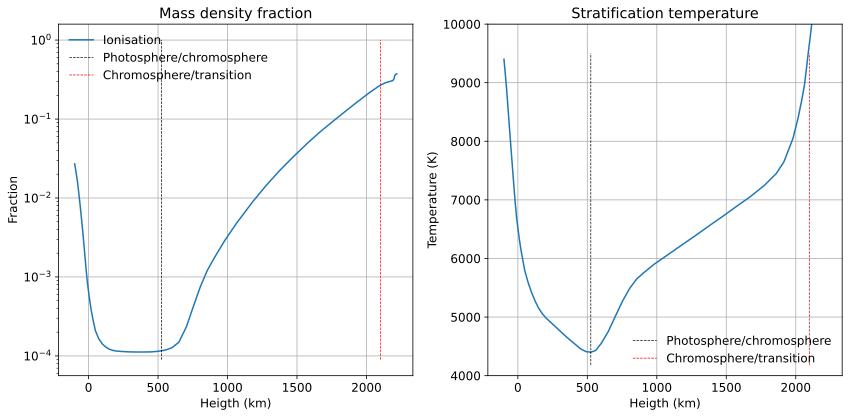

In [22]:
density_p = falc["proton_density"]
tot_dens = density_e + density_p + density_H
ion_frac = density_e / tot_dens

plt.figure("Density and temperature with height", figsize=[12,6])
plt.subplot(121)
plt.plot(height, ion_frac, label="Ionisation")
plt.plot([525,525], [0.8*np.min(ion_frac), 1], "--", lw=0.7, label="Photosphere/chromosphere", color="black")
plt.plot([2100,2100], [0.8*np.min(ion_frac), 1], "--", lw=0.7, label="Chromosphere/transition", color="red")
plt.yscale("log")
plt.xlabel("Heigth (km)")
plt.ylabel("Fraction")
plt.title("Mass density fraction")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(height, temperature)
plt.plot([525,525], [0.95*np.min(temperature.value), 9500], "--", lw=0.7, label="Photosphere/chromosphere", color="black")
plt.plot([2100,2100], [0.95*np.min(temperature.value), 9500], "--", lw=0.7, label="Chromosphere/transition", color="red")
plt.xlabel("Heigth (km)")
plt.ylabel("Temperature (K)")
plt.title("Stratification temperature")
plt.ylim(4000, 10000)
plt.legend()
plt.grid()

plt.tight_layout();

The left plot shows the hydrogen ionisation and the right plot shows the stratification temperature, both as function of height. We notice how both of the plots looks similar but tilted relative to each other. As the ionisation level stays constant at $h \in [200, 500]$ km (photosphere), the temperature in the atmosphere drops linearly. From $h > 500$ km (chromosphere) the temperature begins to rise linearly in two stages. The hydrogen ionisation density rises exponentially and becomes more dominant in the contribution to the total mass density. We remember from project 1 that the ionisation stages from hydrogen in TE is described by the Saha distribution. The Saha distribution of ionisation is temperature dependent ($\propto e^{-1/T}$) which means that as the temperature increase linearly, the ionisation density increases exponentially as we see from the plot above.

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Let us now compare the photon and particle densities. In thermodynamic equilibrium (TE) the radiation is isotropic with intensity $I_\nu = B_\nu$ and has total energy density (Stefan Boltzmann)
    \begin{equation*}
         u = \frac{1}{c} \int\!\!\!\int B_\nu \mathrm{d}\Omega \mathrm{d}\nu
           = \frac{4\sigma}{c} T^4,
      \end{equation*} so that the total photon density for isotropic TE radiation is given, with $u_\nu = \rm{d} u/\rm{d} \nu$, $T$ in K and $N_{\rm phot}$ in photons per m$^3$, by  
    \begin{equation*}
         N_{\rm phot} = \int_0^\infty \frac{u_\nu}{h\nu} \mathrm{d} \nu
            \approx 20\,T^3.
         \label{eq:20T3}
      \end{equation*} 
    This equation gives a reasonable estimate for the photon density at the deepest model location. Compute the value there and compare it to the hydrogen density. Conjecture why this equation is not valid higher up in the atmosphere. 
    
Answer:

</div>

We want to compare the hydrogen density with the photon density first by computing the values at the deepest location in the solar atmosphere and then as a function of height. The hydrogen density is found in the FALC model while the photon density is calculated using the equation above. We will look into what is causing the rise of the photon density as we move further out in the solar atmosphere.

Photon density at the deepest model location h=-100km (above tau_500=1):
1.684938030072768e+19 1 / m3
Hydrogen/photon density ratio:
8018.1


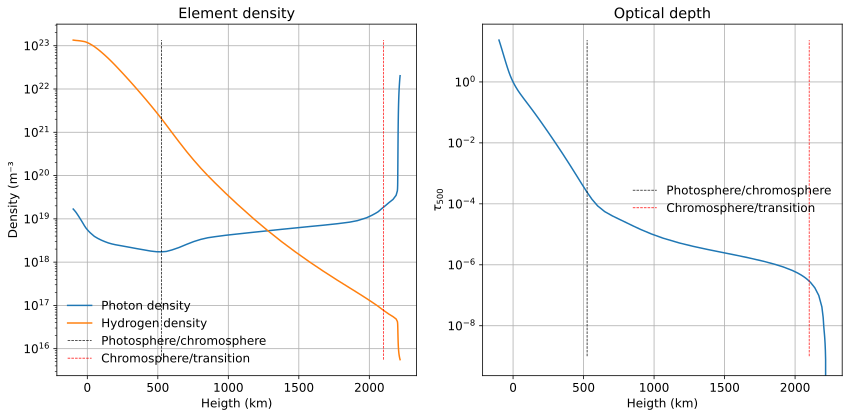

In [26]:
density_photon =  60.42 * (constants.k_B * temperature / (constants.h * constants.c))**3

print("Photon density at the deepest model location h=%ikm (above tau_500=1):" % height[-1].value)
print(density_photon[-1])
print("Hydrogen/photon density ratio:")
print("%.1f" % (density_H[-1] / density_photon[-1]))

plt.figure(figsize=[12,6])
plt.subplot(121)
plt.plot(height, density_photon, label="Photon density")
plt.plot(height, density_H, label="Hydrogen density")
#plt.plot(height, density_He, label="Helium density")
#plt.plot(height, density_e, label="Electron density")
#plt.plot(height, density_p, label="Proton density")
plt.plot([525,525], [np.min(density_H.value), np.max(density_H.value)], "--", lw=0.7, label="Photosphere/chromosphere", color="black")
plt.plot([2100,2100], [np.min(density_H.value), np.max(density_H.value)], "--", lw=0.7, label="Chromosphere/transition", color="red")
plt.xlabel("Heigth (km)")
plt.ylabel("Density (m⁻³")
plt.yscale("log")
plt.title("Element density")
plt.legend()
plt.grid()


tau_500 = falc["tau_500"]
plt.subplot(122)
plt.title("Optical depth")
plt.plot(height, tau_500)
plt.plot([525,525], [1e-9, np.max(tau_500)], "--", lw=0.7, label="Photosphere/chromosphere", color="black")
plt.plot([2100,2100], [1e-9, np.max(tau_500)], "--", lw=0.7, label="Chromosphere/transition", color="red")
plt.yscale("log")
plt.xlabel("Heigth (km)")
plt.ylabel(r"$\tau_{500}$")
plt.legend()
plt.grid()

plt.tight_layout();

We notice from the printouts that the hydrogen is about 8000 more dense than the photons at the deepest model location. We also plotted the hydrogen and photon densities as a function of height and observed that the photon density at some point exceed the hydrogen density. We know that radiation comes from different transition processes and that hydrogen is the dominant element in the Sun. So in theory, the photon density should be lower than the hydrogen density. If we look at the right plot of the optical depth as a function of heigh, we notice that $\tau_{500}$ gets very small, i.e. $\tau_{500} << 1$ which imply that the atmosphere gets transparent. As the atmosphere gets more transparent implicates that the photon density must increase as we look at greater heights. Stefan-Boltzmanns law assume radiation from a black body where $\tau_{500} >> 1$ and therefore the equation above is not valid higher up in the atmosphere.

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* In the upper atmosphere, the photon density there is given by
$$
N_{\rm phot} \approx \frac{60.42}{2\pi}\,\left(\frac{k_B T_{\rm eff}}{hc}\right)^3,
$$
with $T_{\rm eff} = 5777$ K the effective solar temperature (since $\pi B(T_{\rm eff}) = \sigma T_{\rm eff}^3 = {\cal F^+} = \pi \overline{I^+}$ with ${\cal F^+}$ the emergent flux and $\overline{I^+}$ the disk-averaged emergent intensity). Compare it to the hydrogen density at the highest location in the FALC model. The medium there is insensitive to these photons (except those at the centre wavelength of the hydrogen Ly $\alpha$ line), why?
    
Answer:

</div>

Finally, we will use the correct expression for the photon density in the upper solar atmosphere and compare it with the hydrogen density. 

In [28]:
T_eff = 5777 * units.K
density_photon_upper = (60.42/(2*np.pi)) * (constants.k_B * T_eff / (constants.h * constants.c))**3

print("Photon density at the highest model location h=%ikm (above tau_500=1):" % height[0].value)
print(density_photon_upper)
print("Hydrogen/photon density ratio:")
print("%.3e" % (density_H[0] / density_photon_upper))

Photon density at the highest model location h=2218km (above tau_500=1):
6.224831588144017e+17 1 / m3
Hydrogen/photon density ratio:
8.956e-03


Now we notice that the hydrogen is much less dense than the photons by a factor of approximately 100. As mentioned above, $\tau_{500} << 1$ at the highest point in the atmosphere which imply a transparent medium. We remember that this region is part of the transition region between the chromosphere and the corona where the temperature increases exponentially. Most of the radiation traverse throught the medium without interaction except radiation with wavelength corresponding to Ly $\alpha$ line. This line are formed from a bound-bound transition where radiation are emitted when a electron jumps from the first excited state back to ground state in a hydrogen atom. 

### Exercise 2: Observed Solar Continua

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Plot the four spectral distributions together in one figure over the range $\lambda$ = 0-2 μm. Check that the continuum intensity (`i_cont`) reaches $I_\lambda^c$ = 46 kW m$^{-2}$ nm$^{-1}$ sr$^{-1}$  at $\lambda$ 0.41 μm. Explain why the four distributions share the same units and discuss the differences between them.
    
Answer:

</div>

We now want to look at observed data of the continuum radiation emitted by the Sun and plot the four spectral distributions together in one figure over the range  $\lambda  = 0-2 \ \mu$m, and check that the continuum intensity (`i_cont`) read from the file `solspect.dat` reaches $I^c_{\lambda} = 46$ kW m −2  nm −1  sr −1  at  $\lambda = 0.41 \ \mu $m.

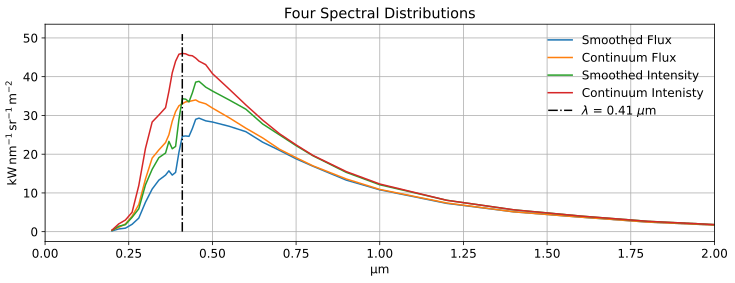

In [47]:
solspect = np.loadtxt("solspect.dat")
erg_s_cm2_um_sr = units.erg / units.s / units.cm**2 / units.um / units.sr * 10**10

Wavelength_solspect = solspect[:,0] * units.um
Flux_smooth = (solspect[:,1] * erg_s_cm2_um_sr).to(i_units)
Flux_cont = (solspect[:,2] * erg_s_cm2_um_sr).to(i_units)
Intensity_smooth = (solspect[:,3] * erg_s_cm2_um_sr).to(i_units)
Intensity_cont = (solspect[:,4] * erg_s_cm2_um_sr).to(i_units)

plt.figure(figsize=[12, 4])

plt.plot(Wavelength_solspect, Flux_smooth, label="Smoothed Flux")
plt.plot(Wavelength_solspect, Flux_cont, label="Continuum Flux")
plt.plot(Wavelength_solspect, Intensity_smooth, label="Smoothed Intensity")
plt.plot(Wavelength_solspect, Intensity_cont, label="Continuum Intenisty")
plt.plot([0.41,0.41],[0, (np.max(Intensity_cont)).value+5], "k-.", label="$\lambda$ = 0.41 $\mu$m")
plt.grid()
plt.legend()
plt.xlim(0,2)
plt.title("Four Spectral Distributions");


Both the flux and the intensity tells us something about the radiation intensity. The difference between them is that the flux contains information about the direction of the radiation intensity whereas the intensity does not. Thus the continuum and smoothed flux will always be smaller or equal to the continuum and smoothed intensity respectively, $I_{\lambda}^c > F_{\lambda}^c$ and $I_{\lambda}^s > F_{\lambda}^s$, which we observe in the plot presented above.

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Convert these spectral distributions into values per frequency bandwidth $\Delta \nu$ = 1 Hz. Plot these also against wavelength. Check: peak $I_\nu^c$ = 42.1 nW m$^{-2}$ Hz$^{-1}$ sr$^{-1}$  at $\lambda$ = 0.80 μm.
    
Answer:

</div>

Next, we want to convert these spectral distributions into values per frequency bandwidth  $\delta \nu  = 1 Hz$. We also want to plot these also against wavelength, and check that the peak for $I^c_{\lambda}  = 42.1$ nW m −2  Hz −1  sr −1  at  $\lambda  = 0.80 \ \mu$m. We first need to change the units, and we can do this by using that

\begin{equation}
 \label{Eq_newunit}
 I_{\nu} d\nu = - I_{\lambda} d\lambda, \\
 \rightarrow I_{\nu} = - I_{\lambda} \frac{d\lambda}{d\nu},\nonumber
\end{equation}

and by using
\begin{equation}
 \label{Eq_dlambda}
 \lambda = \frac{c}{\nu}, \nonumber
\end{equation}

and inserting for $d\lambda / d\nu$, we can find that the expression which needs to be multiplied with $I_\lambda$ in order to get the new units is

\begin{equation}
 \label{Eq_final}
 I_{\nu} = I_{\lambda} \frac{\lambda^2}{c}, \nonumber
\end{equation}

which also need to be multiplied with the old flux.

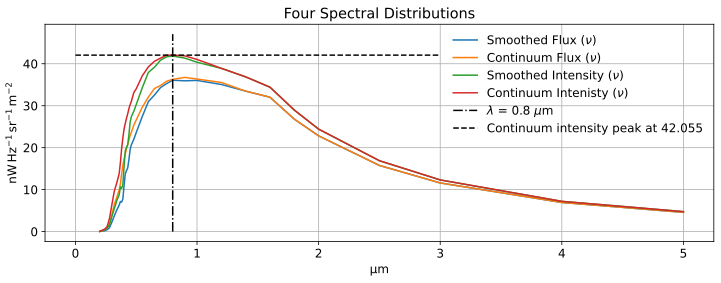

In [48]:
new_units = "nW m-2 sr-1 Hz-1"
nu = (constants.c / Wavelength_solspect).to("Hz")
dlam_dnu = (constants.c/(nu**2)).decompose()

Flux_smooth_nu = (Flux_smooth*dlam_dnu).to(new_units)            #solar smoothed flux
Flux_cont_nu = (Flux_cont*dlam_dnu).to(new_units)                #solar continuum flux
Intensity_smooth_nu = (Intensity_smooth*dlam_dnu).to(new_units)  #solar smooted intenisty
Intensity_cont_nu = (Intensity_cont*dlam_dnu).to(new_units)      #solar continuum intensity

peak = np.max(Intensity_cont_nu).value

plt.figure(figsize=[12, 4])
plt.plot(Wavelength_solspect, Flux_smooth_nu, label=r"Smoothed Flux ($\nu$)")
plt.plot(Wavelength_solspect, Flux_cont_nu, label=r"Continuum Flux ($\nu$)")
plt.plot(Wavelength_solspect, Intensity_smooth_nu, label=r"Smoothed Intensity ($\nu$)")
plt.plot(Wavelength_solspect, Intensity_cont_nu, label=r"Continuum Intenisty ($\nu$)")
plt.plot([0.8,0.8],[0, (np.max(Intensity_cont_nu)).value+5], "k-.", label="$\lambda$ = 0.8 $\mu$m")
plt.plot([0, 3], [peak,peak], "k--", label="Continuum intensity peak at 42.055")
plt.grid()
plt.legend()
#plt.xlabel("Wavelength $(\mu m)$")
plt.title("Four Spectral Distributions");


In the plot presented above we observe a peak with $I_\nu^c$ = 42.055 nW m$^{-2}$ Hz$^{-1}$ sr$^{-1}$ at $\lambda$ = 0.80 μm.

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Try to fit a Planck function to the solar continuum intensity. What rough temperature estimate do you get?
    
Answer:

</div>

Next, we want to fit a Planck function to the solar continuum intensity in order to find which temperature gives the best fitted curve. These calcualtions can be performed by use of the BlackBody function from `astropy` and calculate the difference between this function and the continuum intensity. By doing so, we will find the smallest error which results in a best fitted Planck function. When we know this, we can also find the temperature that corresponds to this curve.

The temperature at lowest error/where the Planck function is best fitted: 6308 K


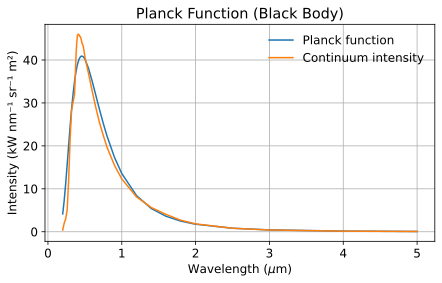

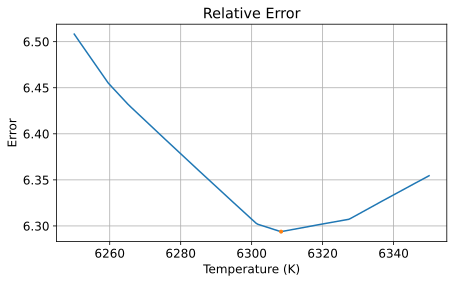

In [51]:
temperature_array = np.linspace(6250,6350,200)*units.K
error = np.zeros(len(temperature_array))

for i,T in enumerate(temperature_array):
    bb_Planck = (BlackBody(T, scale=1.0*units.kW / units.m**2 / units.nm /units.sr)
                (Wavelength_solspect.to("nm"))).value
    error[i] = np.sum(np.abs(bb_Planck - Intensity_cont.value) / (bb_Planck))

print("The temperature at lowest error/where the Planck function is best fitted: %i K" % 
      temperature_array[np.where(error == np.min(error))][0].value)
    
plt.plot(Wavelength_solspect, BlackBody(temperature_array[np.where(error == np.min(error))], 
        scale=1.0*units.kW / units.m**2 /units.nm /units.sr)(Wavelength_solspect.to("nm")), 
        label="Planck function")

plt.plot(Wavelength_solspect, Intensity_cont, label="Continuum intensity")
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel("Intensity (kW nm⁻¹ sr⁻¹ m²)")
plt.legend()
plt.title("Planck Function (Black Body)")
plt.grid()
plt.show()

plt.plot(temperature_array,error)
plt.plot(temperature_array[np.where(error == np.min(error))], np.min(error), ".")
plt.xlabel("Temperature (K)")
plt.ylabel("Error")
plt.title("Relative Error")
plt.grid();


In these two plots, we observe that the best fitted Planck function to the continuum intensity is where the temperature is approximately 6308.29 K, which we see is where the relative error is smallest in the second plot. In the first plot, we see that the continuum intensity almost follows the Planck function perfectly, but the deviation is greatest in the beginning. This shows that the Sun does not radiate like a perfect black body but still a good approximation.

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Invert the Planck function analytically to obtain an equation which converts an intensity distribution $I_\lambda$ into brightness temperature $T_b$ (defined by $B_\lambda(T_b) \equiv I_\lambda$). Code it as a function and use that to plot the brightness temperature of the solar continuum against wavelength. Discuss the shape of this curve. It peaks near $\lambda$ = 1.6 μm. What does that mean for the radiation escape at this wavelength?
    
Answer:

</div>

Now we want to invert the Planck function analytically, where we use the definition $B_\lambda(T_b) \equiv I_{\lambda}$, in order to obtain an equation which converts an intensity distribution $I_\lambda$ into brightness temperature $T_b$. By doing this we can find the maximimum brightness temperature and observe which wavelength this temperature corresponds to. We will perform these calculations by first rewriting the Planck function,

\begin{equation}
 \label{Eq_planck}
 B_{\lambda}(T_b) \equiv I_{\lambda} = \frac{2hc^2}{\lambda^5} \frac{1}{e^{\frac{hc}{\lambda k_B T_b} -1}}, \nonumber
\end{equation}

to an expression for $T_b$ expressed with both $\lambda$ and $I_{\lambda}$,

\begin{equation}
 \label{Eq_Tb}
 T_b = \frac{hc}{\lambda k_B \text{ln}\Big[ \frac{2hc^2}{\lambda^5 I_{\lambda}} +1 \Big]}. \nonumber
\end{equation}

We then want to plot the brightness temperature of the solar continuum against wavelength. We want to use `astropy` when performing these calculations, which means that we need to multiply the Intensity with the unit sr in order to make it unitless before creating the plot.


The maximal brightness temperature: 6711 K


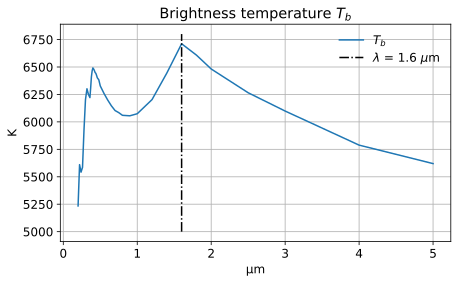

In [52]:
c = constants.c
h = constants.h
kb = constants.k_B

def T_func(Int):
    T_value = (h*c) / (Wavelength_solspect * kb * np.log((2*h*(c**2)) 
            / (Wavelength_solspect**5 * Int) + 1))
    return T_value


print("The maximal brightness temperature: %i K" % np.max(T_func(Intensity_cont*units.sr).decompose()).value)

plt.plot(Wavelength_solspect, T_func(Intensity_cont*units.sr).decompose(), label="$T_b$")
plt.plot([1.6,1.6],[5000, 6800], "k-.", label="$\lambda$ = 1.6 $\mu$m")
plt.title("Brightness temperature $T_b$")
plt.grid()
plt.legend();

From this plot we can say something about the amount of intensity and extinction. If we were to create a plot like this for a perfect Black Body spectrum, and we say that $I_{\lambda} = B_{\lambda} = S_{\lambda} = j_{\lambda} / \alpha_{\lambda}$ is true, the line in this plot would be a straight line at a constant temperature - the characheristic temperature of the Planck function. We observe that this is not a straight line, which indicates that this body does not radiate as a perfect black body. We can tell from this plot that the wavelength which corresponds to the greatest brightness temperature is at $\lambda = 1.6 \ \mu$m. Here the intensity will be at its brightest which imply that the extinction at this specific wavelength must be smallest.

### Exercise 3: Continuous Extinction

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Using the function `compute_hminus_cross_section`, compute and plot the H$^-$ extinction for wavelengths between 300-1000 nm, and for the temperature and density at the solar surface (height = 0) in the FALC model.

    
* Hydrogenic bound-free edges behave just as H1 with maximum extinction at the ionisation limit and decay $\sim \lambda^3$ for smaller wavelengths, as indeed shown by the H1 curve. The H$^-$ bound-free extinction differs strongly from this pattern. Why is it not hydrogenic although due to hydrogen?
    

Answer:

</div>

Now we want to compute and plot the H$^−$ extinction for wavelengths between 300-2000 nm, and for the temperature and density at the solar surface, where the height is defined to be 0 ($\tau_{500} = 1$) in the FALC model. 

In [54]:
def compute_hminus_cross_section(wavelength, temperature, electron_density):
    """
    Computes the H minus extinction cross section, both free-free and
    bound-free as per Gray (1992).
    
    Parameters
    ----------
    wavelength : astropy.units.quantity (array)
        Wavelength(s) to calculate in units of length.
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
    electron_density: astropy.units.quantity (scalar or array)
        Electron density in units of per cubic length.
        
    Returns
    -------
    extinction : astropy.units.quantity (scalar or array)
        Total H- extinction in si units. 
        Shape: shape of temperature + (nwave,)
    """
    # Broadcast to allow function of temperature and wavelength
    temp = temperature[..., nax]
    wave = wavelength[nax]
    theta = 5040 * units.K / temp
    electron_pressure = electron_density[..., nax] * constants.k_B * temp
    # Compute bound-free opacity for H-, following Gray 8.11-8.12
    sigma_coeff = np.array([2.78701e-23, -1.39568e-18,  3.23992e-14, -4.40524e-10,
                               2.64243e-06, -1.18267e-05,  1.99654e+00])
    sigma_bf = np.polyval(sigma_coeff, wave.to_value('AA'))
    sigma_bf = sigma_bf * 1.e-22 * units.m ** 2
    # Set to zero above the H- ionisation limit at 1644.4 nm
    sigma_bf[wave > 1644.2 * units.nm] = 0.
    # convert into bound-free per neutral H atom assuming Saha,  Gray p156
    k_const = 4.158E-10 * units.cm ** 2 / units.dyn
    gray_saha = k_const * electron_pressure.cgs * theta ** 2.5 * 10. ** (0.754 * theta)
    kappa_bf = sigma_bf * gray_saha                    # per neutral H atom
    # correct for stimulated emission
    kappa_bf *= (1 - np.exp(-constants.h * constants.c / (wave * constants.k_B * temp))) 

    # Now compute free-free opacity, following Gray 8.13
    # coefficients for 4th degree polynomials in the log of wavelength (in AA)
    coeffs = np.array([[-0.0533464, 0.76661, -1.685, -2.2763],
                          [-0.142631, 1.99381, -9.2846, 15.2827],
                          [-0.625151, 10.6913, -67.9775, 190.266, -197.789]], dtype="object")
    log_wave = np.log10(wave.to_value('AA'))
    log_theta = np.log10(theta.value)
    tmp = 0
    for i in range(3):
        tmp += np.polyval(coeffs[i], log_wave) * (log_theta ** i)
    kappa_ff = electron_pressure * (10 ** tmp) 
    kappa_ff = kappa_ff * 1e-26 * (units.cm ** 4) / units.dyn
    return kappa_bf + kappa_ff.si


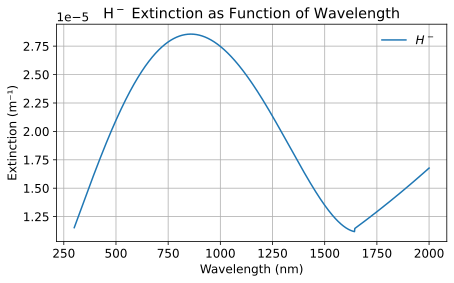

In [63]:
wave = np.linspace(300,2000,1000)*units.nm              #nm
t_0 = temperature[np.where(height==0)]                  #K
dens_0 = falc["electron_density"][np.where(height==0)]  #m-3
H_density = falc["hydrogen_density"] - falc["proton_density"] #m-3
H_ext = np.concatenate(compute_hminus_cross_section(wave, t_0, dens_0))*H_density[np.where(height==0)] #m-1

plt.plot(wave,H_ext, label="$H^-$")
plt.title("H$^-$ Extinction as Function of Wavelength")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Extinction (m⁻¹)")
plt.grid()
plt.legend();

The H$^−$ bound-free extinction differs strongly from the hydrogenic bound-free edge pattern for wavelengths longer than the ionisation limit, as we observe in the plot presented above. A possible explanation for this can be that the binding energy between the atom and the extra electron is weak, thus the second electron is  more easily kicked out even at lower energies/higher wavelengths. In the area $\lambda \sim [260-  1650]$ nm extinction is dominated by the bound-free process and for higher wavelengths, the extinction is dominated by the free-free process. 


<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* How should you plot this variation to make it look like the solar brightness temperature variation with wavelength? Why?
    
Answer:

</div>

In order to make the H$^-$ extinction plot presented in the exercise point above to look like the solar brightness temperature variation with wavelength, all we need to do is invert this plot.

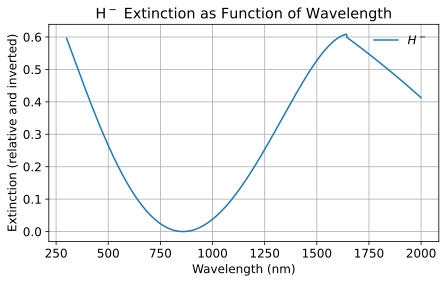

In [60]:
plt.plot(wave, 1-H_ext/np.max(H_ext), label="$H^-$")
plt.title("H$^-$ Extinction as Function of Wavelength")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Extinction (relative and inverted)")
plt.grid()
plt.legend();

We notice that the shape of the curve in the plot presented above now look approximately identical to the brightness temperature plot previously presented in this exercise, for the wavelengths $\lambda \sim [260-2000]$ nm. 
We observe that the peak is at approximately the same wavelength $\lambda = 1.6 \ \mu$m $= 1600$ nm. The small deviation is caused by the fact that we in the plot above only observe extinction from H$^-$ while the brightness temperature plot includes extinction from H1.

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Compute and plot the H$^-$ extinction as a function of height for the FALC model, at $\lambda$ = 0.5 μm. This plot needs to be logarithmic in y, why?
    
Answer:

</div>

Next, we want to compute and plot the H$^−$ extinction at $\lambda = 0.5 \ \mu$m as a function of height for the FALC model by using data from the `falc.dat` file.

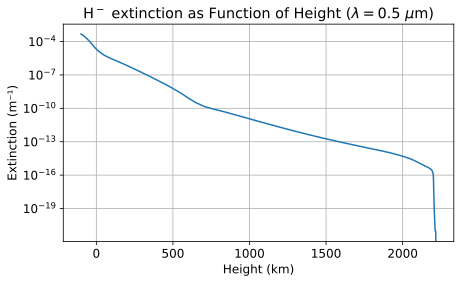

In [69]:
height_FALC = falc["height"].to("km")
e_dens = falc["electron_density"] #m-3
H_ext2 = np.concatenate(compute_hminus_cross_section((0.5*units.um), temperature, e_dens))*H_density #m2 

plt.plot(height_FALC, H_ext2)
plt.yscale("log")
plt.xlabel("Height (km)")
plt.ylabel("Extinction (m⁻¹)")
plt.title(r"H$^-$ extinction as Function of Height ($\lambda = 0.5 \ \mu$m)")
plt.grid();

The extinction drops drastically as height increases for this specific wavelength. We remember from the earlier that the hydrogen density drops exponentially which imply that extinction from H$^-$ must also drop exponentially. Because the extinction vary over multiple orders of magnitude with respect to the height in the solar atmosphere, it is benefical to plot this logarithmic in y in order to not misinterpret any valuable information.

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Now add the Thomson scattering off free electrons to the extinction per m. The Thomson cross-section per electron is the same at all wavelengths and is given by       
\begin{equation*}
        \sigma^{\rm T} = 6.652 \times 10^{-29} \rm{m}^2.
\end{equation*} 
By which height-dependent quantity do you have to multiply this number to obtain extinction per m? Overplot this contribution to the continuous extinction $\alpha_\lambda^c(h)$ in your graph and then overplot the total continuous extinction too.  Note where which effect dominates.
    
Answer:

</div>

We now want to add the Thomson scattering off free electrons to the extinction per m. We want to plot the extinction from $H^-$ as a function of height from the previous exercise together with the extinction from Thomson scattering per meter. A plot with the summation of the two types of extinctions are included.

To obtain the quantity extinction per meter, we need to multipy the Thomson cross-section with electron density which is given in units of per cubic meter. The electron density varies at different heights in the solar atmosphere.

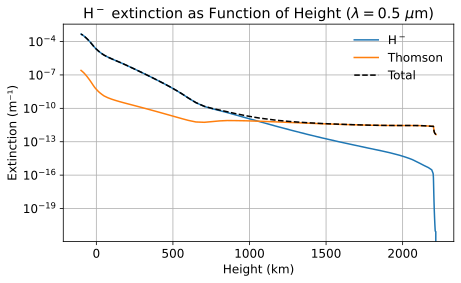

In [74]:
sigma_T = 6.652 * 10**(-29) * units.m**2
extinction = sigma_T * e_dens 

plt.plot(height_FALC, H_ext2, label="H$^-$")
plt.plot(height_FALC, extinction, label="Thomson")
plt.plot(height_FALC, H_ext2+extinction, "k--", label="Total")
plt.yscale("log")
plt.xlabel("Height (km)")
plt.ylabel("Extinction (m⁻¹)")
plt.legend()
plt.title(r"H$^-$ extinction as Function of Height ($\lambda = 0.5 \ \mu$m)")
plt.grid();

The H$^-$ extinction dominates up to 1000 km above the surface, while the extinction from thomson scattering dominates above this point. We observe that the sum of these two, visualized with the dashed line in the plot above, converges toward $\sim 10^{-12}$ m$^-1$ as the height increases. The reason for the small "dip" at approximately 2300 km occurs as we are entering the transition domain which is outside the topic of this project.